# Adjoint Sensitivity Notes on Numerical Computation

## Notes on Numerical Solution

The essential computations for the adjoint sensitivity method is to compute solutions to two systems of linear equations

\begin{align*}
Ax & = b \\
A^Ty & = c
\end{align*}

The most obvious why to proceed is simply to solve these two systems of equation independently of each other. Alternatively, the solution to these equations can be found by solving the symmetric system

$$\begin{bmatrix} 0 & A \\ A^T & 0 \end{bmatrix}
\begin{bmatrix} y \\ x \end{bmatrix} = \begin{bmatrix} b \\ c \end{bmatrix}$$

Iterative algorithms have been developed that simulateously solve both systems of equations with potentially less work then solving them individually.Quoting Lu and Darmofal (2003)

> * The primal and dual problems are solved simultaneously with essentially the
same computational work as solving only one of the problems with the original
QMR algorithm.

The purpose of this notebook is to compare the solution time of various iterative algorithms for the solution of sparse systems of linear equations. The comparison looks at the relative speedup of solving the combined block matrix equations to the independent solution of the forward and adjoint equations.



## References

* Golub, Gene H., Martin Stoll, and Andy Wathen. "Approximation of the scattering amplitude and linear systems." Electron. Trans. Numer. Anal 31.2008 (2008): 178-203. [http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.439.5358&rep=rep1&type=pdf](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.439.5358&rep=rep1&type=pdf)

* Lu, James, and David L. Darmofal. "A quasi-minimal residual method for simultaneous primal-dual solutions and superconvergent functional estimates." SIAM Journal on Scientific Computing 24.5 (2003): 1693-1709. [http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.144.9176&rep=rep1&type=pdf](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.144.9176&rep=rep1&type=pdf)

* Pierce, Niles A., and Michael B. Giles. "Adjoint recovery of superconvergent functionals from PDE approximations." SIAM review 42.2 (2000): 247-264.ll [https://epubs.siam.org/doi/pdf/10.1137/S0036144598349423?casa_token=gU8GJSWSZnYAAAAA:jOFJizYd-tUiPVK3jLkOZNRlasVAQ_tasIVaNq8RGOgSJ2MW85CvTnxzW90KnLDin7HW21gnRCQL](https://epubs.siam.org/doi/pdf/10.1137/S0036144598349423?casa_token=gU8GJSWSZnYAAAAA:jOFJizYd-tUiPVK3jLkOZNRlasVAQ_tasIVaNq8RGOgSJ2MW85CvTnxzW90KnLDin7HW21gnRCQL)

* Stoll, Martin. Solving linear systems using the adjoint. Diss. Oxford University, 2008. See the motivating examples in Chapter 1, and the extensive discussion in Chapter 5. [http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.709.8774&rep=rep1&type=pdf](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.709.8774&rep=rep1&type=pdf)

* Stoll, Martin, and Andrew J. Wathen. "All-at-once solution of time-dependent PDE-constrained optimization problems." (2010).


## Comparison of interative solution algorithms from scipy.sparse.linalg

### Create test problems

In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

spmatrix = scipy.sparse.csr_matrix

# toy problem
A_prob = spmatrix(np.array([[1, 1, -1, 0], [2, 1, 0, -1], [0, 0, 1, 0 ], [0, 0, 0, 1]]))
b_prob = np.array([0, 0, 80, 100]).reshape((4,1))
c_prob = np.array([170, 120, -50, -40]).reshape((4,1))

# random problem
def test_problem(N=25, density=0.2):
    A_prob = scipy.sparse.random(N, N, density=density)
    b_prob = np.random.rand(N, 1)
    c_prob = np.random.rand(N, 1)
    return spmatrix(A_prob), b_prob, c_prob

### Create sparse block matrix

In [2]:
def block_matrix(A_prob, b_prob, c_prob):
    # sparse version of block matrix
    zeros = spmatrix(np.zeros(A_prob.shape))
    A = scipy.sparse.vstack(
            (scipy.sparse.hstack((zeros, spmatrix(A_prob))),
             scipy.sparse.hstack((spmatrix(A_prob.T), zeros))
        )
    )
    A = spmatrix(A)
    xs, ys = A_prob.shape
    plt.figure(figsize=(xs/40, ys/40))
    plt.spy(A, ms=1)
    b = scipy.sparse.vstack((spmatrix(b_prob), spmatrix(c_prob))).toarray()
    return A, b

### Solver comparisons

Matrix size = (500, 500). Average time for 10 runs.
spsolve         combined solution =    85.75 ms  separate solution =    81.59 ms  speedup = 0.95
cg              combined solution =   168.37 ms  separate solution =   593.67 ms  speedup = 3.53
minres          combined solution =   167.77 ms  separate solution =   122.18 ms  speedup = 0.73
qmr             combined solution =   355.49 ms  separate solution =  1250.75 ms  speedup = 3.52


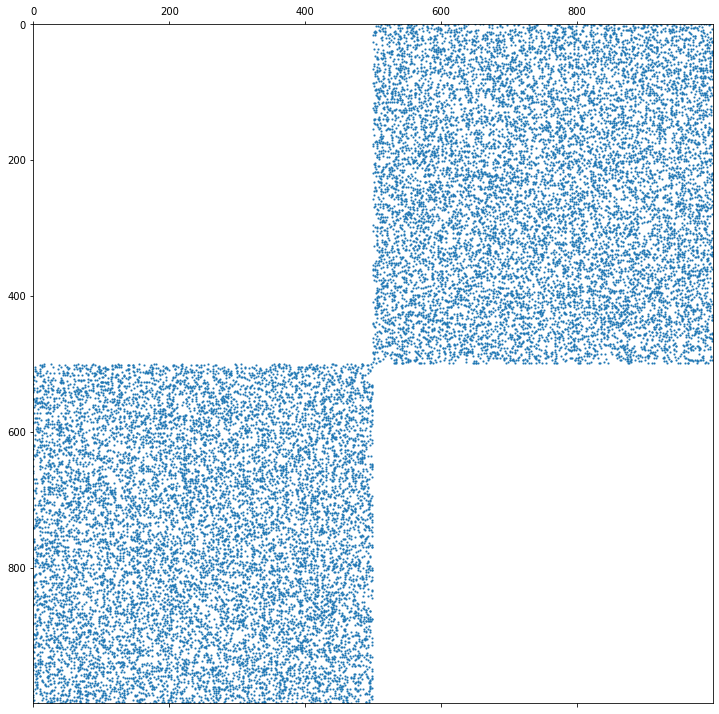

In [3]:
import time
import warnings
import gc
warnings.filterwarnings("ignore", category=DeprecationWarning) 

solvers = [
           scipy.sparse.linalg.spsolve,
           scipy.sparse.linalg.cg,
           #scipy.sparse.linalg.gmres,
           #scipy.sparse.linalg.lgmres,
           scipy.sparse.linalg.minres,
           scipy.sparse.linalg.qmr,
]

K = 10
N = 500

A_prob, b_prob, c_prob = test_problem(N, density=0.05)
A, b = block_matrix(A_prob, b_prob, c_prob)

print(f"Matrix size = {A_prob.shape}. Average time for {K} runs.")
for solver in solvers:
    gc.disable()
    tic = time.time()
    for k in range(K):
        solver(A, b)
    toc = time.time()
    gc.enable()
    ta = (toc - tic)/K

    gc.disable()
    tic = time.time()
    for k in range(K):
        solver(A_prob, b_prob)
        solver(A_prob.T, c_prob)
    toc = time.time()
    gc.enable()
    tb = (toc - tic)/K

    print(f"{solver.__name__:15s} combined solution = {1000*ta:8.2f} ms  separate solution = {1000*tb:8.2f} ms  speedup = {tb/ta:4.2f}")